In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import arviz as az
import pymc3 as pm
import theano.tensor as tt
%config InlineBackend.figure_format = 'retina'
az.style.use('arviz-darkgrid')

In [2]:
# Read the data
howell1 = pd.read_csv('../Data/Howell1.csv',sep=';')

# Normalize the age column
howell1['age'] = StandardScaler().fit_transform(howell1['age'].values.reshape(-1,1))

# Divide dataframe into two equal
d1, d2 = train_test_split(howell1, test_size=0.5, random_state=42)

In [3]:
d1.describe()

,height,weight,age,male
count,272.000000,272.000000,272.000000,272.000000
mean,139.846248,36.518423,-0.007330,0.459559
std,26.206521,14.259042,0.981193,0.499280
min,55.880000,4.847764,-1.415702,0.000000
25%,130.340100,24.408919,-0.788525,0.000000
50%,149.225000,41.276872,-0.161348,0.000000
75%,157.638750,47.520849,0.610562,1.000000
max,172.999400,58.825212,2.829802,1.000000


## Polynomial models

In [14]:
from sklearn.preprocessing import PolynomialFeatures
def plot_polynomial_regressions(d1, xcol, ycol, degree=1, credible_interval=.95, plot_name='hpd', save_plot=True):

    yval = d1[ycol].values
    # Polynomial features
    polynomial_features= PolynomialFeatures(degree=degree, include_bias=False)
    xval = polynomial_features.fit_transform(d1[xcol].values.reshape(-1,1))
    
    with pm.Model() as model_1:
        a = pm.Normal('a', mu=10, sigma=10)
        b = pm.Normal('b', mu=0, sigma=1,shape=(degree))
        sigma = pm.Uniform('sigma', lower=0, upper=10)
        mu = pm.Deterministic('mu', a + tt.dot(xval,b))
        h = pm.Normal('h', mu=mu, sigma=sigma, observed=yval)
        trace_1 = pm.sample(cores=2)
    
    if plot_name=='forest':
        az.plot_forest(trace_1, var_names=['a','b','sigma'], figsize=(6,6), credible_interval=credible_interval)
    
    if plot_name=='hpd':
        fig, ax = plt.subplots(figsize=(6,6))
        mu_mean = trace_1['mu']
        ax.scatter(xval[:,0], yval)
        sorted_xval = np.argsort(xval[:,0])
        ax.plot(xval[sorted_xval,0], mu_mean.mean(0)[sorted_xval], 'C1')

        xseq = np.linspace(np.min(xval[:,0]), np.max(xval[:,0]), 50)
        xplot = polynomial_features.fit_transform(xseq.reshape(-1,1)).T
        mu_pred = trace_1['a'].reshape(-1,1) + np.dot(trace_1['b'],xplot)
        ax.plot(xseq, mu_pred.mean(0), 'k.')
        az.plot_hpd(xseq, mu_pred,
                fill_kwargs={'alpha': 0},
                plot_kwargs={'alpha':1, 'color':'k', 'ls':'--'},ax=ax, credible_interval=credible_interval)
        ax.set_xlabel(xcol)
        ax.set_ylabel(ycol)
        
    if plot_name=='summary':
        print(az.summary(trace_1, ['a','b','sigma'], credible_interval=credible_interval).round(3))
    
    if save_plot:
        filename = 'PolynomialModel_Degree_%d.png' % degree
        plt.savefig(filename)
    model_1.name = 'M%d' % degree
    return model_1,trace_1

/home/amit/anaconda3/envs/stat-rethink-pymc3/lib/python3.7/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -16,102, ||grad|| = 281.68: 100%|██████████| 16/16 [00:00<00:00, 2783.10it/s]  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, b, a]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1202.52draws/s]


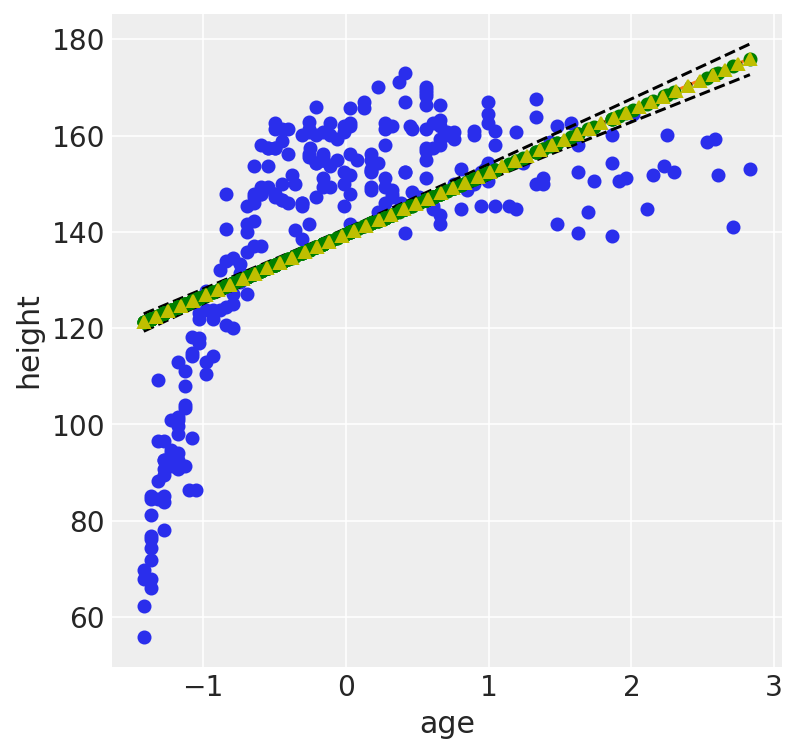

In [15]:
M1,trace1 = plot_polynomial_regressions(d1, xcol='age', ycol='height',degree=1)
M2,trace2 = plot_polynomial_regressions(d1, xcol='age', ycol='height',degree=2)
M3,trace3 = plot_polynomial_regressions(d1, xcol='age', ycol='height',degree=3)
M4,trace4 = plot_polynomial_regressions(d1, xcol='age', ycol='height',degree=4)
M5,trace5 = plot_polynomial_regressions(d1, xcol='age', ycol='height',degree=5)
M6,trace6 = plot_polynomial_regressions(d1, xcol='age', ycol='height',degree=6)

In [13]:
pm.find_MAP?